In [1]:
##############################################################################
# 1) IMPORTS E CONFIGURAÇÕES
##############################################################################
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib as mpl
from pathlib import Path

# Checando GPU (opcional)
if tf.config.list_logical_devices('GPU'):
    print("Treinando com GPU disponível! :)")
else:
    print("GPU não detectada, usando CPU.")

# Criar pasta para salvar figuras (opcional)
IMAGES_PATH = Path("images") / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """ Salva a figura atual """
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

GPU não detectada, usando CPU.


In [2]:
##############################################################################
# 2) CARREGAR E VISUALIZAR MNIST
##############################################################################
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
print("Shapes:", X_train_full.shape, y_train_full.shape, "|", X_test.shape, y_test.shape)

# Converter para float32 e normalizar
X_train_full = X_train_full.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.

X_train, X_val = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_val = y_train_full[:-5000], y_train_full[-5000:]

print("Tamanho do treino:", X_train.shape, y_train.shape)
print("Tamanho da validação:", X_val.shape, y_val.shape)
print("Tamanho do teste:", X_test.shape, y_test.shape)

Shapes: (60000, 28, 28) (60000,) | (10000, 28, 28) (10000,)
Tamanho do treino: (55000, 28, 28) (55000,)
Tamanho da validação: (5000, 28, 28) (5000,)
Tamanho do teste: (10000, 28, 28) (10000,)


In [3]:

##############################################################################
# 3) DEFINIR O VARIATIONAL AUTOENCODER (CONVOLUCIONAL)
##############################################################################
class Sampling(tf.keras.layers.Layer):
    """
    Camada para reparametrização: z = mu + exp(log_var * 0.5)*epsilon
    """
    def call(self, inputs):
        mean, log_var = inputs
        eps = tf.random.normal(tf.shape(log_var), dtype=tf.float32)  # Garante float32
        return mean + tf.exp(log_var / 2) * eps

codings_size = 16  # Dimensão do espaço latente

# ENCODER
inputs = tf.keras.layers.Input(shape=[28, 28], dtype=tf.float32)
Z = keras.layers.Reshape([28, 28, 1])(inputs)

Z = keras.layers.Conv2D(16, 3, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(Z)
Z = keras.layers.MaxPool2D(pool_size=2)(Z)
Z = keras.layers.BatchNormalization()(Z)

Z = keras.layers.Flatten()(Z)
Z = keras.layers.Dense(30, activation='sigmoid')(Z)

codings_mean = tf.keras.layers.Dense(codings_size)(Z)
codings_log_var = tf.keras.layers.Dense(codings_size)(Z)

codings = Sampling()([codings_mean, codings_log_var])

variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings],
    name="variational_encoder"
)

# DECODER
decoder_inputs = tf.keras.layers.Input(shape=[codings_size], dtype=tf.float32)
x = keras.layers.Dense(7 * 7 * 64)(decoder_inputs)
x = keras.layers.Reshape((7, 7, 64))(x)
x = keras.layers.Conv2DTranspose(64, 3, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)
x = keras.layers.Conv2DTranspose(16, 3, padding='same', activation='relu')(x)
x = keras.layers.UpSampling2D(2)(x)

outputs = keras.layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(x)

variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [4]:
##############################################################################
# 4) FUNÇÃO DE PERDA (RECONSTRUÇÃO + KL) DENTRO DO MODELO
##############################################################################

# Criar um modelo customizado para o VAE que adiciona a KL loss corretamente
class VariationalAutoencoder(keras.Model):
    def __init__(self, encoder, decoder, kl_weight=0.001, **kwargs):
        super(VariationalAutoencoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.kl_weight = kl_weight  # Peso ajustável da regularização

    def call(self, inputs):
        codings_mean, codings_log_var, codings = self.encoder(inputs)
        reconstructed = self.decoder(codings)

        # Calcula a KL Divergence com peso reduzido
        kl_loss = self.kl_weight * -0.5 * tf.reduce_sum(
            1.0 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
            axis=-1
        )
        kl_loss = tf.reduce_mean(kl_loss) / 784.0  # Normalização

        self.add_loss(kl_loss)  # Adiciona KL como uma perda extra ao modelo
        return reconstructed

# Criar o modelo final do VAE
variational_ae = VariationalAutoencoder(variational_encoder, variational_decoder)

# Compilar modelo com perda de reconstrução
variational_ae.compile(
    loss="mse",  # Pode ser trocado por 'binary_crossentropy' se necessário
    optimizer="adam"
)


In [5]:
##############################################################################
# 5) TREINAMENTO DO VAE
##############################################################################
history_vae = variational_ae.fit(
    X_train, X_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_val, X_val)
)

Epoch 1/20


c:\Users\lucas\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
c:\Users\lucas\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_13']
Received: inputs=Tensor(shape=(None, 16))
  warnings.warn(msg)


430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0736 - val_loss: 0.0311
Epoch 2/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0259 - val_loss: 0.0161
Epoch 3/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0149 - val_loss: 0.0124
Epoch 4/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0120 - val_loss: 0.0109
Epoch 5/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0106 - val_loss: 0.0101
Epoch 6/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 7/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 8/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 10/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 11/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 12/20
430/430 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/st

 56/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

c:\Users\lucas\anaconda3\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 28, 28))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Users\lucas\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\lucas\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


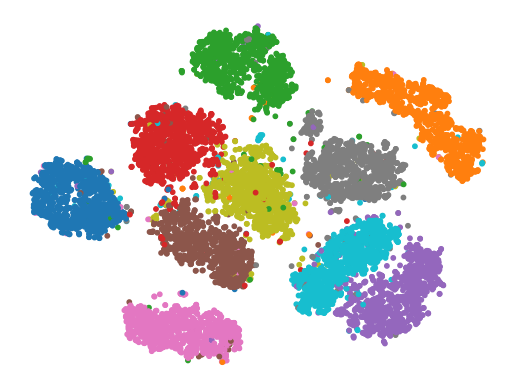

In [6]:
##############################################################################
# 6) VISUALIZANDO O ESPAÇO LATENTE COM t-SNE
##############################################################################
_, _, X_val_latent = variational_encoder.predict(X_test)

# Usar t-SNE para melhor separação de clusters
tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=42)
X_val_2D_tsne = tsne.fit_transform(X_val_latent)

plt.scatter(X_val_2D_tsne[:, 0], X_val_2D_tsne[:, 1], c=y_test, cmap='tab10', s=10)
plt.axis('off')
plt.show()

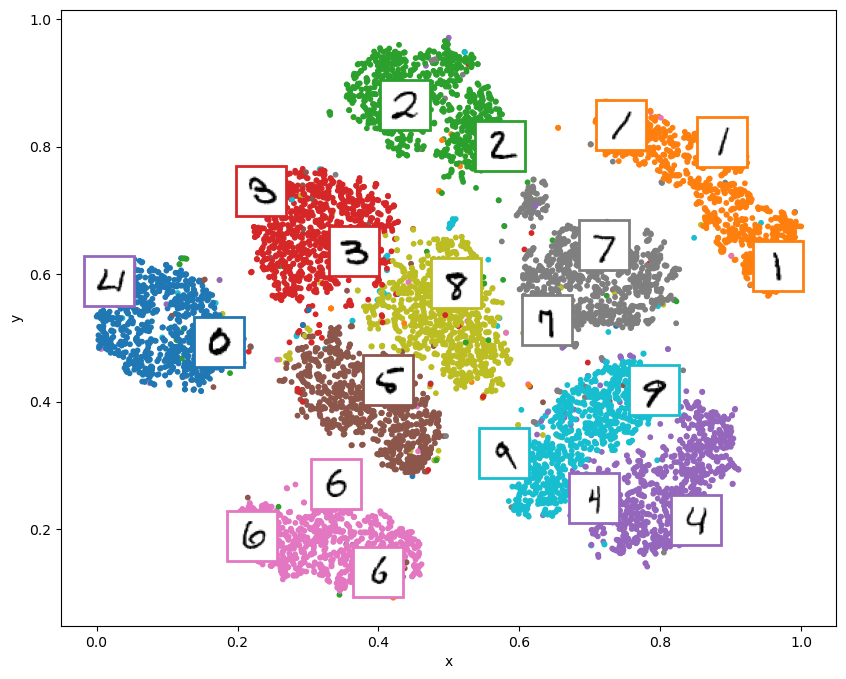

In [7]:
##############################################################################
# 7) ADICIONANDO IMAGENS NO ESPAÇO LATENTE
##############################################################################
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_val_2D_tsne
Z = (Z - Z.min()) / (Z.max() - Z.min())  # Normaliza para a escala 0-1

plt.scatter(Z[:, 0], Z[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])

for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02:  
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2}
        )
        plt.gca().add_artist(imagebox)

plt.xlabel('x')
plt.ylabel('y')
plt.show()